In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reproduction: Shirvany, et. al., "Numerical solution of the nonlinear Schrodinger equation by feedforward neural networks."

We consider the Shroedinger equation in one dimension:
$$\frac{d^2}{dx^2}\Psi(x)+V(x)\Psi(x)=E\Psi(x)$$
For the Potential Well problem with $V(x)=0,\, x\in[0,L]$ and $V(x)=\infty,\, x\notin(0,L)$ the boundary conditions become $\Psi(0)=0$ and $\Psi(L)=0$ with the domain $x\in[0,L]$.

In [2]:
L = 4.
X_train = np.arange(0, L, 0.02) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, L, 0.001) + 1e-8
X_test = X_test.reshape(-1,1)  

In [3]:
bcs = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.constant(0., dtype='float64', shape=X.shape)},
      {'variable':0, 'value':L, 'type':'dirichlet',
        'function':lambda X: tf.constant(0., dtype='float64', shape=X.shape)}]

The authors propose the solution of a form of a almost-shallow network where we have a single hidden layer with $n_h$ units with sigmoid activation function. Output of the hidden layer is passed to an output layer with $n_o=2$ linear units which in the end are reduced by multipication.

In [4]:
class Solution(tf.keras.models.Model):
  def __init__(self, n_i, n_h, n_o=1, activation='sigmoid'):
    super(Solution, self).__init__()
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    self.hidden_layer = tf.keras.layers.Dense(units=n_h, activation=activation)
    self.output_layer = tf.keras.layers.Dense(units=n_o, activation='linear')
    
  def call(self, X):
    X = tf.convert_to_tensor(X)
    response = self.hidden_layer(X)
    response = self.output_layer(X)
    response = tf.math.reduce_prod(response, axis=1)
    return response
  
  def train(self, X, conditions, eigen_value, loss_function, loss_boundary, epochs, verbose=True, message_frequency=1, learning_rate=0.1, optimizer_name='Adam'):
    if not isinstance(epochs, int) or epochs < 1:
      raise Exception('epochs parameter should be a positive integer.')
    if not isinstance(message_frequency, int) or message_frequency < 1:
      raise Exception(
                'message_frequency parameter should be a positive integer.')
    optimizer = 0
    if optimizer_name == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    train_loss = tf.keras.metrics.Mean('train')
    @tf.function
    def train_step(X, eigen_value):
      with tf.GradientTape() as tape:
        loss = loss_function(self, X, eigen_value)
      gradients = tape.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(
                  zip(gradients, self.trainable_variables))
      
    @tf.function
    def train_boundary(conditions):
      with tf.GradientTape() as tape:
        loss = loss_boundary(self, conditions)
      gradients = tape.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(
                  zip(gradients, self.trainable_variables))
      
    for epoch in range(epochs):
      for x in X:
        x_tensor = tf.reshape(x, shape=(1, X.shape[1]))
        train_step(x_tensor, eigen_value)
      train_boundary(conditions)
      train_loss(loss_function(self, X, eigen_value) + loss_boundary(self, conditions))
      if (epoch+1) % message_frequency == 0:
        print(f'Epoch: {epoch+1} Loss: {train_loss.result().numpy()}')

Accroding to the paper:

>The ANN is trained via the gradient-descent back-propagation method with momentum
term for minimizing the non-negative energy function that is formulated from Schrodinger equation Eq. (6)
and the available boundary conditions.

and

>In the train
state of the network the adjustable parameters of the networks (weights and biases) are tuned by a proper
learning algorithm to minimize the energy function of the network. We train the network via the fast converge
gradient-descend back-propagation method with momentum term [7,23,24] for the non-negative energy func-
tion.

We concluded that it can realised by using the Adam optimizer with online learning.

The loss is defined by sum of unsupervised minimalization of the equation and by supervised optimization for MSE for the boundary conditions:
$$Loss(N)=\sum_i \left(\Delta\Psi(N(x_i))+E\Psi(N(x_i))\right)^2 + \sum_k (\Psi(N(x_k))-C_k)^2$$

In [5]:
def loss(network, X, eigen_value):
  X = tf.convert_to_tensor(X)
  with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      tape1.watch(X)
      tape2.watch(X)
      response = network(X)
    grads = tape2.gradient(response, X)
  laplace = tape1.gradient(grads, X)
#   half = tf.constant(0.5, shape=(X.shape[0], 1), dtype='float64')
  eigen_value_tensor = tf.constant(eigen_value, shape=(X.shape[0], 1), dtype='float64')
  loss = tf.square(laplace + eigen_value_tensor * response)
  return loss      

In [6]:
def loss_boundary(network, conditions):
  loss = 0
  for condition in conditions:
    temp_X = tf.convert_to_tensor(np.array([condition['value']]).reshape((1,1)))
    loss += tf.square(network(temp_X) - condition['function'](temp_X))
  return loss      

The working size of the network found by the autors is $n_h=40$.

In [7]:
sol = Solution(n_i=1, n_h=40, n_o=2)

Let's check if such a solution finds the eigen function corresponidng to the eigen_value $E=0.61$ for $n=1$

In [8]:
sol.train(X=X_train, conditions=bcs, eigen_value=0.61, loss_function=loss, loss_boundary=loss_boundary, epochs=100, message_frequency=1, learning_rate=0.1, optimizer_name='Adam')

W0426 12:00:59.529928 139856621168384 deprecation.py:323] From /home/raroog/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:167: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
W0426 12:01:00.240021 139856621168384 optimizer_v2.py:928] Gradients does not exist for variables ['solution/dense/kernel:0', 'solution/dense/bias:0'] when minimizing the loss.
W0426 12:01:02.871162 139856621168384 optimizer_v2.py:928] Gradients does not exist for variables ['solution/dense/kernel:0', 'solution/dense/bias:0'] when minimizing the loss.
W0426 12:01:04.792938 139856621168384 optimizer_v2.py:928] Gradients does not exist for variables ['solution/dense/kernel:0', 'solution/dense/bias:0'] when minimizing the loss.


Epoch: 1 Loss: 0.4467480480670929
Epoch: 2 Loss: 0.23088325560092926
Epoch: 3 Loss: 0.15392233431339264
Epoch: 4 Loss: 0.11544187366962433
Epoch: 5 Loss: 0.09235359728336334
Epoch: 6 Loss: 0.07696142047643661
Epoch: 7 Loss: 0.06596701592206955
Epoch: 8 Loss: 0.05772121623158455
Epoch: 9 Loss: 0.05130782723426819
Epoch: 10 Loss: 0.04617712274193764
Epoch: 11 Loss: 0.04197928309440613
Epoch: 12 Loss: 0.038481082767248154
Epoch: 13 Loss: 0.03552106395363808
Epoch: 14 Loss: 0.03298389911651611
Epoch: 15 Loss: 0.03078502044081688
Epoch: 16 Loss: 0.028860989958047867
Epoch: 17 Loss: 0.02716330625116825
Epoch: 18 Loss: 0.025654250755906105
Epoch: 19 Loss: 0.024304034188389778
Epoch: 20 Loss: 0.023088837042450905
Epoch: 21 Loss: 0.0219893716275692
Epoch: 22 Loss: 0.020989855751395226
Epoch: 23 Loss: 0.020079532638192177
Epoch: 24 Loss: 0.03788989409804344
Epoch: 25 Loss: 0.03734467178583145
Epoch: 26 Loss: 0.03598064184188843
Epoch: 27 Loss: 0.03471137955784798
Epoch: 28 Loss: 0.03347558900713

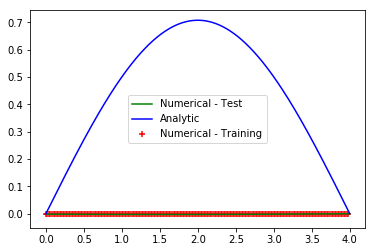

In [9]:
pred_train = sol.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
pred_test = sol(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
plt.plot(X_test, np.sin(np.pi/L*X_test)/np.sqrt(2), c='b', label='Analytic')
plt.legend()
plt.show()

Without much supprise, the network converges to the trivial vanishing solution of the equation.

By analytic considerations, we know that for $n=1$ the maximum of the eigenfunction is for $x=L/2$ and is equal to $\Psi(L/2)=2^{-0.5}$, so let's add it as a boudary point.

In [10]:
bcs2 = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':lambda X: tf.constant(0., dtype='float64', shape=X.shape)},
      {'variable':0, 'value':L, 'type':'dirichlet',
        'function':lambda X: tf.constant(0., dtype='float64', shape=X.shape)},
      {'variable':0, 'value':L*0.5, 'type':'dirichlet',
        'function':lambda X: tf.constant(np.power(2,-0.5), dtype='float64', shape=X.shape)}]

In [11]:
sol2 = Solution(n_i=1, n_h=40, n_o=2)

In [12]:
sol2.train(X=X_train, conditions=bcs2, eigen_value=0.61, loss_function=loss, loss_boundary=loss_boundary, epochs=10000, message_frequency=1, learning_rate=0.1, optimizer_name='Adam')

W0426 12:01:42.745836 139856621168384 optimizer_v2.py:928] Gradients does not exist for variables ['solution_1/dense_2/kernel:0', 'solution_1/dense_2/bias:0'] when minimizing the loss.
W0426 12:01:46.326100 139856621168384 optimizer_v2.py:928] Gradients does not exist for variables ['solution_1/dense_2/kernel:0', 'solution_1/dense_2/bias:0'] when minimizing the loss.
W0426 12:01:48.632952 139856621168384 optimizer_v2.py:928] Gradients does not exist for variables ['solution_1/dense_2/kernel:0', 'solution_1/dense_2/bias:0'] when minimizing the loss.


Epoch: 1 Loss: 0.5014920830726624
Epoch: 2 Loss: 0.8675087690353394
Epoch: 3 Loss: 0.7288134098052979
Epoch: 4 Loss: 0.6735530495643616
Epoch: 5 Loss: 0.6435960531234741
Epoch: 6 Loss: 1.2149609327316284
Epoch: 7 Loss: 1.1100873947143555
Epoch: 8 Loss: 1.0112714767456055
Epoch: 9 Loss: 0.9215537309646606
Epoch: 10 Loss: 0.9834977984428406
Epoch: 11 Loss: 0.9586741924285889
Epoch: 12 Loss: 0.9224101305007935
Epoch: 13 Loss: 0.9079650640487671
Epoch: 14 Loss: 0.877129316329956
Epoch: 15 Loss: 0.8478962182998657
Epoch: 16 Loss: 0.9725539088249207
Epoch: 17 Loss: 0.9439196586608887
Epoch: 18 Loss: 0.918000340461731
Epoch: 19 Loss: 0.9788933396339417
Epoch: 20 Loss: 0.9539173245429993
Epoch: 21 Loss: 0.9318183660507202
Epoch: 22 Loss: 1.0084855556488037
Epoch: 23 Loss: 0.9866470694541931
Epoch: 24 Loss: 0.9670106172561646
Epoch: 25 Loss: 0.9599677324295044
Epoch: 26 Loss: 0.9406589865684509
Epoch: 27 Loss: 0.9600604772567749
Epoch: 28 Loss: 0.9525790214538574
Epoch: 29 Loss: 0.9369612336158

Epoch: 233 Loss: 1.3614015579223633
Epoch: 234 Loss: 1.377373218536377
Epoch: 235 Loss: 1.3730981349945068
Epoch: 236 Loss: 1.3687059879302979
Epoch: 237 Loss: 1.365451693534851
Epoch: 238 Loss: 1.3612614870071411
Epoch: 239 Loss: 1.357284665107727
Epoch: 240 Loss: 1.3532869815826416
Epoch: 241 Loss: 1.3487422466278076
Epoch: 242 Loss: 1.3438899517059326
Epoch: 243 Loss: 1.3398271799087524
Epoch: 244 Loss: 1.3358616828918457
Epoch: 245 Loss: 1.332573652267456
Epoch: 246 Loss: 1.3310567140579224
Epoch: 247 Loss: 1.3274084329605103
Epoch: 248 Loss: 1.3238468170166016
Epoch: 249 Loss: 1.3202708959579468
Epoch: 250 Loss: 1.3206744194030762
Epoch: 251 Loss: 1.3175369501113892
Epoch: 252 Loss: 1.3142842054367065
Epoch: 253 Loss: 1.318892478942871
Epoch: 254 Loss: 1.3154531717300415
Epoch: 255 Loss: 1.311955213546753
Epoch: 256 Loss: 1.3091946840286255
Epoch: 257 Loss: 1.3067829608917236
Epoch: 258 Loss: 1.3034871816635132
Epoch: 259 Loss: 1.299821138381958
Epoch: 260 Loss: 1.2958767414093018

Epoch: 462 Loss: 1.151625394821167
Epoch: 463 Loss: 1.1501818895339966
Epoch: 464 Loss: 1.1486831903457642
Epoch: 465 Loss: 1.14701509475708
Epoch: 466 Loss: 1.145043969154358
Epoch: 467 Loss: 1.143470048904419
Epoch: 468 Loss: 1.1418882608413696
Epoch: 469 Loss: 1.1405304670333862
Epoch: 470 Loss: 1.1423845291137695
Epoch: 471 Loss: 1.1410293579101562
Epoch: 472 Loss: 1.1402442455291748
Epoch: 473 Loss: 1.1388170719146729
Epoch: 474 Loss: 1.1393107175827026
Epoch: 475 Loss: 1.137819528579712
Epoch: 476 Loss: 1.143290638923645
Epoch: 477 Loss: 1.1417438983917236
Epoch: 478 Loss: 1.1403933763504028
Epoch: 479 Loss: 1.139054536819458
Epoch: 480 Loss: 1.1376925706863403
Epoch: 481 Loss: 1.1363530158996582
Epoch: 482 Loss: 1.1348401308059692
Epoch: 483 Loss: 1.133493423461914
Epoch: 484 Loss: 1.1338238716125488
Epoch: 485 Loss: 1.1322133541107178
Epoch: 486 Loss: 1.1304030418395996
Epoch: 487 Loss: 1.1307485103607178
Epoch: 488 Loss: 1.1295162439346313
Epoch: 489 Loss: 1.13009774684906
Epo

Epoch: 692 Loss: 1.028964638710022
Epoch: 693 Loss: 1.0278874635696411
Epoch: 694 Loss: 1.0267577171325684
Epoch: 695 Loss: 1.0255540609359741
Epoch: 696 Loss: 1.0246412754058838
Epoch: 697 Loss: 1.023903727531433
Epoch: 698 Loss: 1.0231610536575317
Epoch: 699 Loss: 1.0224286317825317
Epoch: 700 Loss: 1.0216916799545288
Epoch: 701 Loss: 1.0232609510421753
Epoch: 702 Loss: 1.0225036144256592
Epoch: 703 Loss: 1.021588921546936
Epoch: 704 Loss: 1.0207775831222534
Epoch: 705 Loss: 1.0200740098953247
Epoch: 706 Loss: 1.0189436674118042
Epoch: 707 Loss: 1.0180152654647827
Epoch: 708 Loss: 1.0175400972366333
Epoch: 709 Loss: 1.0167269706726074
Epoch: 710 Loss: 1.0159969329833984
Epoch: 711 Loss: 1.0152604579925537
Epoch: 712 Loss: 1.014500379562378
Epoch: 713 Loss: 1.0136383771896362
Epoch: 714 Loss: 1.0139820575714111
Epoch: 715 Loss: 1.0142120122909546
Epoch: 716 Loss: 1.013731598854065
Epoch: 717 Loss: 1.0133135318756104
Epoch: 718 Loss: 1.0124905109405518
Epoch: 719 Loss: 1.01485848426818

Epoch: 922 Loss: 0.9707149863243103
Epoch: 923 Loss: 0.9701924324035645
Epoch: 924 Loss: 0.9699589610099792
Epoch: 925 Loss: 0.9694151282310486
Epoch: 926 Loss: 0.9748393297195435
Epoch: 927 Loss: 0.9760514497756958
Epoch: 928 Loss: 0.9752606749534607
Epoch: 929 Loss: 0.9744833111763
Epoch: 930 Loss: 0.9736823439598083
Epoch: 931 Loss: 0.9728197455406189
Epoch: 932 Loss: 0.9719390273094177
Epoch: 933 Loss: 0.9711306691169739
Epoch: 934 Loss: 0.9703590869903564
Epoch: 935 Loss: 0.9695357084274292
Epoch: 936 Loss: 0.9686712622642517
Epoch: 937 Loss: 0.9679607152938843
Epoch: 938 Loss: 0.9673535227775574
Epoch: 939 Loss: 0.966744065284729
Epoch: 940 Loss: 0.9659672379493713
Epoch: 941 Loss: 0.9659731388092041
Epoch: 942 Loss: 0.9659643173217773
Epoch: 943 Loss: 0.9657467603683472
Epoch: 944 Loss: 0.965354323387146
Epoch: 945 Loss: 0.9672489762306213
Epoch: 946 Loss: 0.9679282307624817
Epoch: 947 Loss: 0.9674343466758728
Epoch: 948 Loss: 0.9669586420059204
Epoch: 949 Loss: 0.96639704704284

Epoch: 1147 Loss: 0.9924964308738708
Epoch: 1148 Loss: 0.9920758605003357
Epoch: 1149 Loss: 0.9916582107543945
Epoch: 1150 Loss: 0.9912465214729309
Epoch: 1151 Loss: 0.9914543628692627
Epoch: 1152 Loss: 0.9909737706184387
Epoch: 1153 Loss: 0.9904773831367493
Epoch: 1154 Loss: 0.9898528456687927
Epoch: 1155 Loss: 0.9914435744285583
Epoch: 1156 Loss: 0.995145857334137
Epoch: 1157 Loss: 1.0412256717681885
Epoch: 1158 Loss: 1.050995111465454
Epoch: 1159 Loss: 1.0505197048187256
Epoch: 1160 Loss: 1.0498952865600586
Epoch: 1161 Loss: 1.0491859912872314
Epoch: 1162 Loss: 1.0484291315078735
Epoch: 1163 Loss: 1.0476549863815308
Epoch: 1164 Loss: 1.0468846559524536
Epoch: 1165 Loss: 1.046128273010254
Epoch: 1166 Loss: 1.0453896522521973
Epoch: 1167 Loss: 1.0446709394454956
Epoch: 1168 Loss: 1.0439717769622803
Epoch: 1169 Loss: 1.0432876348495483
Epoch: 1170 Loss: 1.0426114797592163
Epoch: 1171 Loss: 1.041936993598938
Epoch: 1172 Loss: 1.0412589311599731
Epoch: 1173 Loss: 1.040570616722107
Epoch:

Epoch: 1370 Loss: 1.037213683128357
Epoch: 1371 Loss: 1.036794900894165
Epoch: 1372 Loss: 1.0364264249801636
Epoch: 1373 Loss: 1.0360618829727173
Epoch: 1374 Loss: 1.0356501340866089
Epoch: 1375 Loss: 1.0352463722229004
Epoch: 1376 Loss: 1.0355336666107178
Epoch: 1377 Loss: 1.0350897312164307
Epoch: 1378 Loss: 1.0354808568954468
Epoch: 1379 Loss: 1.035090446472168
Epoch: 1380 Loss: 1.0346158742904663
Epoch: 1381 Loss: 1.0341951847076416
Epoch: 1382 Loss: 1.0337352752685547
Epoch: 1383 Loss: 1.0333505868911743
Epoch: 1384 Loss: 1.0329524278640747
Epoch: 1385 Loss: 1.0325413942337036
Epoch: 1386 Loss: 1.0322246551513672
Epoch: 1387 Loss: 1.0327939987182617
Epoch: 1388 Loss: 1.0324057340621948
Epoch: 1389 Loss: 1.032171607017517
Epoch: 1390 Loss: 1.0318502187728882
Epoch: 1391 Loss: 1.0314295291900635
Epoch: 1392 Loss: 1.0308833122253418
Epoch: 1393 Loss: 1.030339002609253
Epoch: 1394 Loss: 1.0316457748413086
Epoch: 1395 Loss: 1.031489610671997
Epoch: 1396 Loss: 1.0310766696929932
Epoch: 

Epoch: 1595 Loss: 1.1089798212051392
Epoch: 1596 Loss: 1.1084049940109253
Epoch: 1597 Loss: 1.1078407764434814
Epoch: 1598 Loss: 1.1072806119918823
Epoch: 1599 Loss: 1.1067053079605103
Epoch: 1600 Loss: 1.1061325073242188
Epoch: 1601 Loss: 1.1055961847305298
Epoch: 1602 Loss: 1.105035662651062
Epoch: 1603 Loss: 1.1045962572097778
Epoch: 1604 Loss: 1.1043124198913574
Epoch: 1605 Loss: 1.1039496660232544
Epoch: 1606 Loss: 1.1035618782043457
Epoch: 1607 Loss: 1.103145956993103
Epoch: 1608 Loss: 1.1037986278533936
Epoch: 1609 Loss: 1.1034345626831055
Epoch: 1610 Loss: 1.1029610633850098
Epoch: 1611 Loss: 1.1026723384857178
Epoch: 1612 Loss: 1.1023390293121338
Epoch: 1613 Loss: 1.10197114944458
Epoch: 1614 Loss: 1.1015812158584595
Epoch: 1615 Loss: 1.1013610363006592
Epoch: 1616 Loss: 1.1009358167648315
Epoch: 1617 Loss: 1.1004990339279175
Epoch: 1618 Loss: 1.100263237953186
Epoch: 1619 Loss: 1.099843978881836
Epoch: 1620 Loss: 1.099604845046997
Epoch: 1621 Loss: 1.0991628170013428
Epoch: 1

Epoch: 1819 Loss: 1.159507393836975
Epoch: 1820 Loss: 1.159488558769226
Epoch: 1821 Loss: 1.1597466468811035
Epoch: 1822 Loss: 1.1593642234802246
Epoch: 1823 Loss: 1.1589349508285522
Epoch: 1824 Loss: 1.1584821939468384
Epoch: 1825 Loss: 1.1581671237945557
Epoch: 1826 Loss: 1.1578044891357422
Epoch: 1827 Loss: 1.1573407649993896
Epoch: 1828 Loss: 1.1569160223007202
Epoch: 1829 Loss: 1.1564077138900757
Epoch: 1830 Loss: 1.1571084260940552
Epoch: 1831 Loss: 1.15763521194458
Epoch: 1832 Loss: 1.1648693084716797
Epoch: 1833 Loss: 1.168000340461731
Epoch: 1834 Loss: 1.167611837387085
Epoch: 1835 Loss: 1.1672123670578003
Epoch: 1836 Loss: 1.1668068170547485
Epoch: 1837 Loss: 1.166394829750061
Epoch: 1838 Loss: 1.1659740209579468
Epoch: 1839 Loss: 1.1655404567718506
Epoch: 1840 Loss: 1.1650885343551636
Epoch: 1841 Loss: 1.164610505104065
Epoch: 1842 Loss: 1.1640973091125488
Epoch: 1843 Loss: 1.163551926612854
Epoch: 1844 Loss: 1.1630358695983887
Epoch: 1845 Loss: 1.1625463962554932
Epoch: 184

Epoch: 2043 Loss: 1.129936933517456
Epoch: 2044 Loss: 1.1294806003570557
Epoch: 2045 Loss: 1.129026174545288
Epoch: 2046 Loss: 1.1286051273345947
Epoch: 2047 Loss: 1.128190517425537
Epoch: 2048 Loss: 1.1277600526809692
Epoch: 2049 Loss: 1.1274055242538452
Epoch: 2050 Loss: 1.1270455121994019
Epoch: 2051 Loss: 1.126744270324707
Epoch: 2052 Loss: 1.1270653009414673
Epoch: 2053 Loss: 1.1315749883651733
Epoch: 2054 Loss: 1.1311341524124146
Epoch: 2055 Loss: 1.1307101249694824
Epoch: 2056 Loss: 1.1303869485855103
Epoch: 2057 Loss: 1.129980206489563
Epoch: 2058 Loss: 1.1295723915100098
Epoch: 2059 Loss: 1.1291167736053467
Epoch: 2060 Loss: 1.1288028955459595
Epoch: 2061 Loss: 1.128452181816101
Epoch: 2062 Loss: 1.1281638145446777
Epoch: 2063 Loss: 1.127880573272705
Epoch: 2064 Loss: 1.1275537014007568
Epoch: 2065 Loss: 1.1278539896011353
Epoch: 2066 Loss: 1.127512812614441
Epoch: 2067 Loss: 1.1271966695785522
Epoch: 2068 Loss: 1.126949667930603
Epoch: 2069 Loss: 1.1266735792160034
Epoch: 207

Epoch: 2267 Loss: 1.0980808734893799
Epoch: 2268 Loss: 1.097774863243103
Epoch: 2269 Loss: 1.0974594354629517
Epoch: 2270 Loss: 1.0971686840057373
Epoch: 2271 Loss: 1.0968190431594849
Epoch: 2272 Loss: 1.0964277982711792
Epoch: 2273 Loss: 1.0962566137313843
Epoch: 2274 Loss: 1.0960150957107544
Epoch: 2275 Loss: 1.0957540273666382
Epoch: 2276 Loss: 1.0954536199569702
Epoch: 2277 Loss: 1.095183253288269
Epoch: 2278 Loss: 1.0949325561523438
Epoch: 2279 Loss: 1.094704031944275
Epoch: 2280 Loss: 1.0944396257400513
Epoch: 2281 Loss: 1.0952215194702148
Epoch: 2282 Loss: 1.0949712991714478
Epoch: 2283 Loss: 1.0947202444076538
Epoch: 2284 Loss: 1.0946416854858398
Epoch: 2285 Loss: 1.0943657159805298
Epoch: 2286 Loss: 1.0941121578216553
Epoch: 2287 Loss: 1.0938389301300049
Epoch: 2288 Loss: 1.0936226844787598
Epoch: 2289 Loss: 1.093310832977295
Epoch: 2290 Loss: 1.0931059122085571
Epoch: 2291 Loss: 1.0928210020065308
Epoch: 2292 Loss: 1.0937373638153076
Epoch: 2293 Loss: 1.0934776067733765
Epoch

Epoch: 2490 Loss: 1.0728247165679932
Epoch: 2491 Loss: 1.07302725315094
Epoch: 2492 Loss: 1.0731490850448608
Epoch: 2493 Loss: 1.0729016065597534
Epoch: 2494 Loss: 1.0726584196090698
Epoch: 2495 Loss: 1.0724232196807861
Epoch: 2496 Loss: 1.0721733570098877
Epoch: 2497 Loss: 1.0719212293624878
Epoch: 2498 Loss: 1.0716404914855957
Epoch: 2499 Loss: 1.0713329315185547
Epoch: 2500 Loss: 1.0709753036499023
Epoch: 2501 Loss: 1.0708516836166382
Epoch: 2502 Loss: 1.0706759691238403
Epoch: 2503 Loss: 1.0712761878967285
Epoch: 2504 Loss: 1.0712577104568481
Epoch: 2505 Loss: 1.0710262060165405
Epoch: 2506 Loss: 1.0708117485046387
Epoch: 2507 Loss: 1.0706030130386353
Epoch: 2508 Loss: 1.0719069242477417
Epoch: 2509 Loss: 1.0717276334762573
Epoch: 2510 Loss: 1.0714645385742188
Epoch: 2511 Loss: 1.0713433027267456
Epoch: 2512 Loss: 1.0711133480072021
Epoch: 2513 Loss: 1.070866346359253
Epoch: 2514 Loss: 1.0705485343933105
Epoch: 2515 Loss: 1.071479320526123
Epoch: 2516 Loss: 1.0713118314743042
Epoch

Epoch: 2713 Loss: 1.1037487983703613
Epoch: 2714 Loss: 1.103466272354126
Epoch: 2715 Loss: 1.1032475233078003
Epoch: 2716 Loss: 1.1030149459838867
Epoch: 2717 Loss: 1.1027995347976685
Epoch: 2718 Loss: 1.1025893688201904
Epoch: 2719 Loss: 1.102360725402832
Epoch: 2720 Loss: 1.1021171808242798
Epoch: 2721 Loss: 1.1018710136413574
Epoch: 2722 Loss: 1.1015856266021729
Epoch: 2723 Loss: 1.101283073425293
Epoch: 2724 Loss: 1.101351261138916
Epoch: 2725 Loss: 1.1011292934417725
Epoch: 2726 Loss: 1.1008721590042114
Epoch: 2727 Loss: 1.1006971597671509
Epoch: 2728 Loss: 1.10093092918396
Epoch: 2729 Loss: 1.1024750471115112
Epoch: 2730 Loss: 1.1022319793701172
Epoch: 2731 Loss: 1.1019854545593262
Epoch: 2732 Loss: 1.101920247077942
Epoch: 2733 Loss: 1.101731300354004
Epoch: 2734 Loss: 1.1015002727508545
Epoch: 2735 Loss: 1.1014679670333862
Epoch: 2736 Loss: 1.101218819618225
Epoch: 2737 Loss: 1.1011537313461304
Epoch: 2738 Loss: 1.1009361743927002
Epoch: 2739 Loss: 1.1007171869277954
Epoch: 274

Epoch: 2937 Loss: 1.102575421333313
Epoch: 2938 Loss: 1.1022816896438599
Epoch: 2939 Loss: 1.101988434791565
Epoch: 2940 Loss: 1.1016790866851807
Epoch: 2941 Loss: 1.101381540298462
Epoch: 2942 Loss: 1.1011123657226562
Epoch: 2943 Loss: 1.1008455753326416
Epoch: 2944 Loss: 1.1005663871765137
Epoch: 2945 Loss: 1.1003050804138184
Epoch: 2946 Loss: 1.1000323295593262
Epoch: 2947 Loss: 1.0997883081436157
Epoch: 2948 Loss: 1.0995720624923706
Epoch: 2949 Loss: 1.0993362665176392
Epoch: 2950 Loss: 1.0992213487625122
Epoch: 2951 Loss: 1.0990147590637207
Epoch: 2952 Loss: 1.098781704902649
Epoch: 2953 Loss: 1.0985757112503052
Epoch: 2954 Loss: 1.0983670949935913
Epoch: 2955 Loss: 1.0981355905532837
Epoch: 2956 Loss: 1.098043441772461
Epoch: 2957 Loss: 1.0978420972824097
Epoch: 2958 Loss: 1.0980091094970703
Epoch: 2959 Loss: 1.0978072881698608
Epoch: 2960 Loss: 1.0976184606552124
Epoch: 2961 Loss: 1.0973981618881226
Epoch: 2962 Loss: 1.097166895866394
Epoch: 2963 Loss: 1.0969457626342773
Epoch: 

Epoch: 3160 Loss: 1.112251877784729
Epoch: 3161 Loss: 1.1120277643203735
Epoch: 3162 Loss: 1.1118137836456299
Epoch: 3163 Loss: 1.1116008758544922
Epoch: 3164 Loss: 1.1114192008972168
Epoch: 3165 Loss: 1.1112083196640015
Epoch: 3166 Loss: 1.1112693548202515
Epoch: 3167 Loss: 1.111052393913269
Epoch: 3168 Loss: 1.1108007431030273
Epoch: 3169 Loss: 1.111274003982544
Epoch: 3170 Loss: 1.1113635301589966
Epoch: 3171 Loss: 1.1111613512039185
Epoch: 3172 Loss: 1.1109851598739624
Epoch: 3173 Loss: 1.111708164215088
Epoch: 3174 Loss: 1.1114928722381592
Epoch: 3175 Loss: 1.1112855672836304
Epoch: 3176 Loss: 1.1110376119613647
Epoch: 3177 Loss: 1.110758662223816
Epoch: 3178 Loss: 1.1104954481124878
Epoch: 3179 Loss: 1.1103099584579468
Epoch: 3180 Loss: 1.110042691230774
Epoch: 3181 Loss: 1.111366868019104
Epoch: 3182 Loss: 1.1135212182998657
Epoch: 3183 Loss: 1.1133555173873901
Epoch: 3184 Loss: 1.1130778789520264
Epoch: 3185 Loss: 1.1127877235412598
Epoch: 3186 Loss: 1.1125075817108154
Epoch: 3

Epoch: 3383 Loss: 1.1920130252838135
Epoch: 3384 Loss: 1.191713571548462
Epoch: 3385 Loss: 1.1914187669754028
Epoch: 3386 Loss: 1.1911296844482422
Epoch: 3387 Loss: 1.1908481121063232
Epoch: 3388 Loss: 1.1905757188796997
Epoch: 3389 Loss: 1.190314769744873
Epoch: 3390 Loss: 1.190068006515503
Epoch: 3391 Loss: 1.1898382902145386
Epoch: 3392 Loss: 1.1896289587020874
Epoch: 3393 Loss: 1.1894441843032837
Epoch: 3394 Loss: 1.189286708831787
Epoch: 3395 Loss: 1.1891621351242065
Epoch: 3396 Loss: 1.1890687942504883
Epoch: 3397 Loss: 1.1890183687210083
Epoch: 3398 Loss: 1.1889984607696533
Epoch: 3399 Loss: 1.1889965534210205
Epoch: 3400 Loss: 1.1890443563461304
Epoch: 3401 Loss: 1.1891335248947144
Epoch: 3402 Loss: 1.1890863180160522
Epoch: 3403 Loss: 1.1892980337142944
Epoch: 3404 Loss: 1.18905770778656
Epoch: 3405 Loss: 1.1894607543945312
Epoch: 3406 Loss: 1.1891772747039795
Epoch: 3407 Loss: 1.188910722732544
Epoch: 3408 Loss: 1.1886788606643677
Epoch: 3409 Loss: 1.1884058713912964
Epoch: 3

Epoch: 3607 Loss: 1.1716326475143433
Epoch: 3608 Loss: 1.1714377403259277
Epoch: 3609 Loss: 1.17158842086792
Epoch: 3610 Loss: 1.1714016199111938
Epoch: 3611 Loss: 1.1712150573730469
Epoch: 3612 Loss: 1.1710091829299927
Epoch: 3613 Loss: 1.1711063385009766
Epoch: 3614 Loss: 1.1709637641906738
Epoch: 3615 Loss: 1.1718881130218506
Epoch: 3616 Loss: 1.171694040298462
Epoch: 3617 Loss: 1.1714839935302734
Epoch: 3618 Loss: 1.1712905168533325
Epoch: 3619 Loss: 1.171095371246338
Epoch: 3620 Loss: 1.1709460020065308
Epoch: 3621 Loss: 1.170729160308838
Epoch: 3622 Loss: 1.1705429553985596
Epoch: 3623 Loss: 1.1703606843948364
Epoch: 3624 Loss: 1.1701470613479614
Epoch: 3625 Loss: 1.1698840856552124
Epoch: 3626 Loss: 1.1698229312896729
Epoch: 3627 Loss: 1.1697287559509277
Epoch: 3628 Loss: 1.1695926189422607
Epoch: 3629 Loss: 1.1705409288406372
Epoch: 3630 Loss: 1.170332431793213
Epoch: 3631 Loss: 1.170133113861084
Epoch: 3632 Loss: 1.1699355840682983
Epoch: 3633 Loss: 1.1697362661361694
Epoch: 3

Epoch: 3831 Loss: 1.1502074003219604
Epoch: 3832 Loss: 1.149997353553772
Epoch: 3833 Loss: 1.1497474908828735
Epoch: 3834 Loss: 1.1498922109603882
Epoch: 3835 Loss: 1.1498762369155884
Epoch: 3836 Loss: 1.1496981382369995
Epoch: 3837 Loss: 1.1495195627212524
Epoch: 3838 Loss: 1.149322509765625
Epoch: 3839 Loss: 1.1491162776947021
Epoch: 3840 Loss: 1.1488639116287231
Epoch: 3841 Loss: 1.1495705842971802
Epoch: 3842 Loss: 1.149656057357788
Epoch: 3843 Loss: 1.1494861841201782
Epoch: 3844 Loss: 1.1493109464645386
Epoch: 3845 Loss: 1.1491400003433228
Epoch: 3846 Loss: 1.1489933729171753
Epoch: 3847 Loss: 1.1488200426101685
Epoch: 3848 Loss: 1.148691177368164
Epoch: 3849 Loss: 1.1484735012054443
Epoch: 3850 Loss: 1.1486639976501465
Epoch: 3851 Loss: 1.1485071182250977
Epoch: 3852 Loss: 1.1483805179595947
Epoch: 3853 Loss: 1.1481379270553589
Epoch: 3854 Loss: 1.147900104522705
Epoch: 3855 Loss: 1.147728443145752
Epoch: 3856 Loss: 1.1476205587387085
Epoch: 3857 Loss: 1.1474305391311646
Epoch: 

Epoch: 4055 Loss: 1.1316120624542236
Epoch: 4056 Loss: 1.1314483880996704
Epoch: 4057 Loss: 1.1312735080718994
Epoch: 4058 Loss: 1.1314879655838013
Epoch: 4059 Loss: 1.13131582736969
Epoch: 4060 Loss: 1.1314617395401
Epoch: 4061 Loss: 1.1313074827194214
Epoch: 4062 Loss: 1.131122350692749
Epoch: 4063 Loss: 1.1313621997833252
Epoch: 4064 Loss: 1.1311875581741333
Epoch: 4065 Loss: 1.1309577226638794
Epoch: 4066 Loss: 1.1307777166366577
Epoch: 4067 Loss: 1.1325193643569946
Epoch: 4068 Loss: 1.1641405820846558
Epoch: 4069 Loss: 1.1660144329071045
Epoch: 4070 Loss: 1.1666803359985352
Epoch: 4071 Loss: 1.1712229251861572
Epoch: 4072 Loss: 1.1746728420257568
Epoch: 4073 Loss: 1.1782389879226685
Epoch: 4074 Loss: 1.178606629371643
Epoch: 4075 Loss: 1.1784510612487793
Epoch: 4076 Loss: 1.1782208681106567
Epoch: 4077 Loss: 1.1780242919921875
Epoch: 4078 Loss: 1.177829384803772
Epoch: 4079 Loss: 1.1776584386825562
Epoch: 4080 Loss: 1.1775002479553223
Epoch: 4081 Loss: 1.1773686408996582
Epoch: 40

Epoch: 4279 Loss: 1.1677672863006592
Epoch: 4280 Loss: 1.1676106452941895
Epoch: 4281 Loss: 1.1674433946609497
Epoch: 4282 Loss: 1.1672788858413696
Epoch: 4283 Loss: 1.1673285961151123
Epoch: 4284 Loss: 1.1671638488769531
Epoch: 4285 Loss: 1.1670031547546387
Epoch: 4286 Loss: 1.1668387651443481
Epoch: 4287 Loss: 1.166674017906189
Epoch: 4288 Loss: 1.1666663885116577
Epoch: 4289 Loss: 1.1665083169937134
Epoch: 4290 Loss: 1.1664239168167114
Epoch: 4291 Loss: 1.166264295578003
Epoch: 4292 Loss: 1.1661546230316162
Epoch: 4293 Loss: 1.1659895181655884
Epoch: 4294 Loss: 1.1658210754394531
Epoch: 4295 Loss: 1.1656590700149536
Epoch: 4296 Loss: 1.1657631397247314
Epoch: 4297 Loss: 1.165608525276184
Epoch: 4298 Loss: 1.1654391288757324
Epoch: 4299 Loss: 1.1652954816818237
Epoch: 4300 Loss: 1.1656752824783325
Epoch: 4301 Loss: 1.165520429611206
Epoch: 4302 Loss: 1.165364146232605
Epoch: 4303 Loss: 1.1651930809020996
Epoch: 4304 Loss: 1.165540099143982
Epoch: 4305 Loss: 1.1653661727905273
Epoch: 

Epoch: 4503 Loss: 1.1458007097244263
Epoch: 4504 Loss: 1.145660161972046
Epoch: 4505 Loss: 1.1455419063568115
Epoch: 4506 Loss: 1.145382046699524
Epoch: 4507 Loss: 1.1452505588531494
Epoch: 4508 Loss: 1.1450386047363281
Epoch: 4509 Loss: 1.1448332071304321
Epoch: 4510 Loss: 1.1446794271469116
Epoch: 4511 Loss: 1.144554853439331
Epoch: 4512 Loss: 1.1444014310836792
Epoch: 4513 Loss: 1.144230842590332
Epoch: 4514 Loss: 1.1440935134887695
Epoch: 4515 Loss: 1.1441456079483032
Epoch: 4516 Loss: 1.1439989805221558
Epoch: 4517 Loss: 1.143907070159912
Epoch: 4518 Loss: 1.1437541246414185
Epoch: 4519 Loss: 1.143869400024414
Epoch: 4520 Loss: 1.1437269449234009
Epoch: 4521 Loss: 1.1435834169387817
Epoch: 4522 Loss: 1.1434606313705444
Epoch: 4523 Loss: 1.1433030366897583
Epoch: 4524 Loss: 1.143330454826355
Epoch: 4525 Loss: 1.1431723833084106
Epoch: 4526 Loss: 1.143225073814392
Epoch: 4527 Loss: 1.143101453781128
Epoch: 4528 Loss: 1.1429556608200073
Epoch: 4529 Loss: 1.142802357673645
Epoch: 4530

Epoch: 4727 Loss: 1.129472255706787
Epoch: 4728 Loss: 1.1293249130249023
Epoch: 4729 Loss: 1.129624605178833
Epoch: 4730 Loss: 1.129490852355957
Epoch: 4731 Loss: 1.1302651166915894
Epoch: 4732 Loss: 1.1301085948944092
Epoch: 4733 Loss: 1.129968523979187
Epoch: 4734 Loss: 1.1298309564590454
Epoch: 4735 Loss: 1.1296848058700562
Epoch: 4736 Loss: 1.1295831203460693
Epoch: 4737 Loss: 1.1294326782226562
Epoch: 4738 Loss: 1.1292896270751953
Epoch: 4739 Loss: 1.1297558546066284
Epoch: 4740 Loss: 1.1296229362487793
Epoch: 4741 Loss: 1.1294811964035034
Epoch: 4742 Loss: 1.1294678449630737
Epoch: 4743 Loss: 1.1293158531188965
Epoch: 4744 Loss: 1.1293063163757324
Epoch: 4745 Loss: 1.1295605897903442
Epoch: 4746 Loss: 1.129426121711731
Epoch: 4747 Loss: 1.1292939186096191
Epoch: 4748 Loss: 1.129152536392212
Epoch: 4749 Loss: 1.1290817260742188
Epoch: 4750 Loss: 1.128945231437683
Epoch: 4751 Loss: 1.1287996768951416
Epoch: 4752 Loss: 1.1291903257369995
Epoch: 4753 Loss: 1.129058837890625
Epoch: 47

KeyboardInterrupt: 

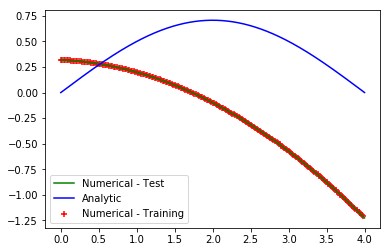

In [13]:
pred_train2 = sol2.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
pred_test2 = sol2(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
plt.scatter(X_train, pred_train2, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test2, c='g', label='Numerical - Test')
plt.plot(X_test, np.sin(np.pi/L*X_test)/np.sqrt(2), c='b', label='Analytic')
plt.legend()
plt.show()